# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import numpy as np



from sklearn.preprocessing import OrdinalEncoder



In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Признаки**
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

**Целевой признак**
* Exited — факт ухода клиента

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Удалим обьекты с пропущенным признаком Tenure, для более точного обучения модели в дальнейшем.

In [5]:
df = df.dropna(subset = ["Tenure"], axis = 0)
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Столбцы: RowNumber, CustomerId и Surname - можно удалить. Данные признаки не влияют на факт ухода клиента. Для обучения модели они не нужны.

In [6]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)
df.shape

(9091, 11)

Преобразуем категориальные признаки нашего датафрейма в численные, техникой прямого кодирования с защитой от дамми-ловушки.


In [7]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 12 columns):
CreditScore          9091 non-null int64
Age                  9091 non-null int64
Tenure               9091 non-null float64
Balance              9091 non-null float64
NumOfProducts        9091 non-null int64
HasCrCard            9091 non-null int64
IsActiveMember       9091 non-null int64
EstimatedSalary      9091 non-null float64
Exited               9091 non-null int64
Geography_Germany    9091 non-null uint8
Geography_Spain      9091 non-null uint8
Gender_Male          9091 non-null uint8
dtypes: float64(3), int64(6), uint8(3)
memory usage: 736.9 KB


Разобьем данные на тренировочную, валидационную и тестовую выборки.

In [8]:
target = df_ohe['Exited'] # Целевой признак
features = df_ohe.drop(['Exited'],axis=1) # Признаки

train_features, valid_test_features, train_target, valid_test_target = train_test_split(
    features, target, test_size=0.4, random_state=42)

valid_features, test_features, valid_target, test_target = train_test_split(
    valid_test_features, valid_test_target, test_size=0.5, random_state=42)

print('Размер обучающей выборки', train_features.shape[0])
print('Размер валидационной выборки', valid_features.shape[0])
print('Размер тестовой выборки', test_features.shape[0])

Размер обучающей выборки 5454
Размер валидационной выборки 1818
Размер тестовой выборки 1819


Так как в данных присутствуют колличественные признаки с разными разбросами значений, их нужно масштабировать.  
Приведем данные к одному масштабу методом стандартизации.

In [9]:
numeric = ['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']
scaler = StandardScaler()
scaler.fit(train_features[numeric])
pd.options.mode.chained_assignment = None
train_features[numeric] = scaler.transform(train_features[numeric])
valid_features[numeric] = scaler.transform(valid_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])

## Исследование задачи

Исследуем баланс классов

In [10]:
target.value_counts()

0    7237
1    1854
Name: Exited, dtype: int64

Объектов отрицательного класса почти в 4 раза больше.  
Обучим модели без учёта дисбаланса.

* **Модель "Решающее дерево"**

In [11]:
f1_best = 0
for depth in range(2,10):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model_tree.fit(train_features,train_target)
    prediction = model_tree.predict(valid_features)
    f1 = f1_score(valid_target, prediction)
    if f1 > f1_best:
        f1_best = f1
        depth_best = depth
print("f1_best = ", round(f1_best, 3), "при max_depth =", depth_best)

f1_best =  0.523 при max_depth = 8


* **Модель "Случайный лес"**

In [12]:
f1_best = 0
for depth in range(2, 20):
    for est in range(2, 20):
        model_forest = RandomForestClassifier(random_state=42, max_depth=depth, n_estimators=est)
        model_forest.fit(train_features,train_target)
        prediction = model_forest.predict(valid_features)
        f1 = f1_score(valid_target, prediction)
        if f1 > f1_best:
            f1_best = f1
            depth_best = depth
            best_est = est
print("f1_best = ", round(f1_best, 3), "при max_depth =", depth_best, "и n_estimators =", best_est )

f1_best =  0.554 при max_depth = 17 и n_estimators = 17


* **Модель "Логистическая регрессия"**

In [13]:
model_logistic = LogisticRegression(random_state=42, solver = 'liblinear')
model_logistic.fit(train_features,train_target)
predictions = model_logistic.predict(valid_features)
f1 = f1_score(valid_target,prediction)
print("f1 = ", round(f1, 3))

f1 =  0.506


Рассматривая результаты работы моделей, обученных без учёта дисбаланса классов, можно сделать вывод, что лучший результат показал "Случайный лес": **F1-мера =  0.554** при max_depth = 17 и n_estimators = 17.

## Борьба с дисбалансом

Для борьбы с дисбалансом выполним сравнение моделей:

1. С взвешенными классами (параметр class_weight)
2. С уменьшенной выборкой (Downsampling)
3. С увеличенной выборкой (Upsampling)

* **Придадим объектам редкого класса больший вес (параметр class_weight)**

In [14]:
f1_best = 0
for depth in range(2,10):
    model_tree_weight = DecisionTreeClassifier(max_depth=depth, random_state=42, class_weight='balanced')
    model_tree_weight.fit(train_features,train_target)
    prediction = model_tree_weight.predict(valid_features)
    f1 = f1_score(valid_target, prediction)
    if f1 > f1_best:
        f1_best = f1
        depth_best = depth
print('Решающее дерево (class_weight)')
print("f1_best = ", round(f1_best, 3), "при max_depth =", depth_best)

Решающее дерево (class_weight)
f1_best =  0.573 при max_depth = 5


In [15]:
f1_best = 0
for depth in range(2, 10):
    for est in range(2, 20):
        model_forest_weight = RandomForestClassifier(
            random_state=42, max_depth=depth, n_estimators=est, class_weight='balanced')
        model_forest_weight.fit(train_features,train_target)
        prediction = model_forest_weight.predict(valid_features)
        f1 = f1_score(valid_target, prediction)
        if f1 > f1_best:
            f1_best = f1
            depth_best = depth
            best_est = est
print('Случайный лес (class_weight)')
print("f1_best = ", round(f1_best, 3), "при max_depth =", depth_best, "и n_estimators =", best_est )

Случайный лес (class_weight)
f1_best =  0.633 при max_depth = 7 и n_estimators = 17


In [16]:
model_logistic_weight = LogisticRegression(random_state=42, solver = 'liblinear', class_weight='balanced')
model_logistic_weight.fit(train_features,train_target)
predictions = model_logistic_weight.predict(valid_features)
f1 = f1_score(valid_target,prediction)
print('Логистическая регрессия (class_weight)')
print("f1 = ", round(f1, 3))

Логистическая регрессия (class_weight)
f1 =  0.503


F-мера значительно выросла у Решающего дерева и Случайного леса, но немного снизилась у Логической регрессии.  
Лучшее значение по прежнему у Случайного леса: **F1-мера = 0.633** при max_depth = 7 и n_estimators = 17.

* **Сделаем объекты частого класса не такими частыми (Downsampling)**

In [17]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(train_features, train_target, 0.25)

print(target_downsampled.value_counts())

1    1111
0    1086
Name: Exited, dtype: int64


In [18]:
f1_best = 0
for depth in range(2,10):
    model_tree_down = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model_tree_down.fit(features_downsampled,target_downsampled)
    prediction = model_tree_down.predict(valid_features)
    f1 = f1_score(valid_target, prediction)
    if f1 > f1_best:
        f1_best = f1
        depth_best = depth
print('Решающее дерево (Downsampling)')
print("f1_best = ", round(f1_best, 3), "при max_depth =", depth_best)

Решающее дерево (Downsampling)
f1_best =  0.541 при max_depth = 6


In [19]:
f1_best = 0
for depth in range(2, 10):
    for est in range(2, 25):
        model_forest_down = RandomForestClassifier(random_state=42, max_depth=depth, n_estimators=est)
        model_forest_down.fit(features_downsampled,target_downsampled)
        prediction = model_forest_down.predict(valid_features)
        f1 = f1_score(valid_target, prediction)
        if f1 > f1_best:
            f1_best = f1
            depth_best = depth
            best_est = est
print('Случайный лес (Downsampling)')
print("f1_best = ", round(f1_best, 3), "при max_depth =", depth_best, "и n_estimators =", best_est )

Случайный лес (Downsampling)
f1_best =  0.613 при max_depth = 7 и n_estimators = 20


In [20]:
model_logistic_down = LogisticRegression(random_state=42, solver = 'liblinear')
model_logistic_down.fit(train_features,train_target)
predictions = model_logistic_down.predict(valid_features)
f1 = f1_score(valid_target,prediction)
print('Логистическая регрессия (Downsampling)')
print("f1 = ", round(f1, 3))

Логистическая регрессия (Downsampling)
f1 =  0.583


F-мера выросла у всех трёх моделей.  
Лучшее значение у Случайного леса: **F1-мера = 0.613** при max_depth = 7 и n_estimators = 20.

* **Сделаем объекты редкого класса не такими редкими в данных (Upsampling)**

In [21]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(train_features, train_target, 4)

print(target_upsampled.value_counts())

1    4444
0    4343
Name: Exited, dtype: int64


In [22]:
f1_best = 0
for depth in range(2,10):
    model_tree_up = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model_tree_up.fit(features_upsampled, target_upsampled)
    prediction = model_tree_up.predict(valid_features)
    f1 = f1_score(valid_target, prediction)
    if f1 > f1_best:
        f1_best = f1
        depth_best = depth
print('Решающее дерево (Upsampling)')
print("f1_best = ", round(f1_best, 3), "при max_depth =", depth_best)

Решающее дерево (Upsampling)
f1_best =  0.57 при max_depth = 4


In [23]:
f1_best = 0
for depth in range(2, 10):
    for est in range(2, 20):
        model_forest_up = RandomForestClassifier(random_state=42, max_depth=depth, n_estimators=est)
        model_forest_up.fit(features_upsampled, target_upsampled)
        prediction = model_forest_up.predict(valid_features)
        f1 = f1_score(valid_target, prediction)
        if f1 > f1_best:
            f1_best = f1
            depth_best = depth
            best_est = est
print('Случайный лес (Upsampling)')
print("f1_best = ", round(f1_best, 3), "при max_depth =", depth_best, "и n_estimators =", best_est )

Случайный лес (Upsampling)
f1_best =  0.622 при max_depth = 5 и n_estimators = 14


In [24]:
model_logistic_up = LogisticRegression(random_state=42, solver = 'liblinear')
model_logistic_up.fit(features_upsampled, target_upsampled)
predictions = model_logistic_up.predict(valid_features)
f1 = f1_score(valid_target,prediction)
print('Логистическая регрессия (Upsampling)')
print("f1 = ", round(f1, 3))

Логистическая регрессия (Upsampling)
f1 =  0.603


F-мера выросла у всех трёх моделей.  
Лучшее значение у Случайного леса: **F1-мера = 0.622** при max_depth = 5 и n_estimators = 14.

**Самое высокое значение F1-мера = 0.633 получилось у модели Случайного леса с взвешенными классами при max_depth = 7 и n_estimators = 17.**

## Тестирование модели

* **Проверим нашу лучшую модель на тестовой выборке**

In [25]:
model_forest_best = RandomForestClassifier(random_state=42, max_depth=7, n_estimators=17, class_weight='balanced')
model_forest_best.fit(train_features,train_target)
prediction = model_forest_best.predict(test_features)
f1 = f1_score(test_target, prediction)
print("f1_score = ", round(f1, 3))

f1_score =  0.602


На тестовой выборке значение **F1-меры = 0.602**. Оно получилось ниже чем на валидационной выборке, т.е. модель не много переобучена. При этом мы преодолели порог F1 = 0.59, требуемый в проекте.

* **Выведем ROC-кривую и AUC-ROC для нашей лучшей модели**

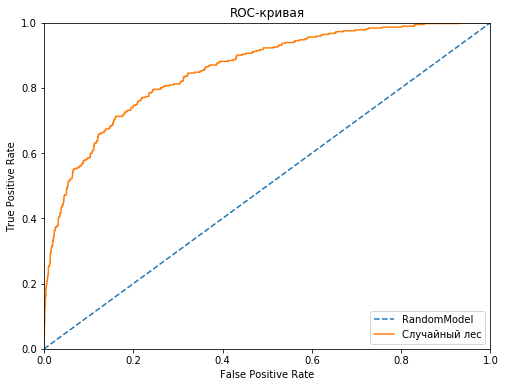

AUC-ROC = 0.855


In [26]:
plt.figure(figsize=[8,6])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
model_forest_best = RandomForestClassifier(random_state=42, max_depth=7, n_estimators=17, class_weight='balanced')
model_forest_best.fit(train_features,train_target)
probabilities_test = model_forest_best.predict_proba(test_features)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_test)
auc_roc = roc_auc_score(test_target, probabilities_one_test)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('RandomModel','Случайный лес'), loc= 'lower right')
plt.show()

print('AUC-ROC =', round(auc_roc, 3))

Мы получили достаточно большое значение площади под кривой **AUC-ROC = 0.855**, следовательно качество нашей модели на много выше чем у случайной.

## Общий вывод

В результате реботы над проектом была выбрана лучшая модель: **модель Случайного леса со взвешенными классами**   
Параметры, дающие лучший результат: **'max_depth': 7, 'n_estimators': 17**  
Лучший показатель F1 метрики: **0.602**   
Показатель ROC-AUC: **0.855**  